In [1]:
# import necessary files
import os
import tensorflow as tf
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

#load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [2]:
def tensor_to_image(tensor):
    """Converts tensors to PIL image format

    Args:
        tensor (tf.Tensor): tensor object to be converted to PIL image

    Returns:
        PIL.Image.fromarray: output image
    """

    # resize image to 255
    tensor = tensor*255

    # convert tensor to numpy array for easy manipulation
    array_tensor = np.array(tensor, dtype=np.uint8)

    # 3-D: [height, width, channels]
    # 4-D: [batch, height, width, channels]
    if np.ndim(array_tensor) > 3: # if the tensor has more than 3 dimensions,
        assert array_tensor.shape[0] == 1 # ensure it has only 1 batch
        array_tensor = array_tensor[0] # and replace with the batch.

    return PIL.Image.fromarray(array_tensor) # return image converted from tensor

In [3]:
# test image
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
# test styling image
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

In [4]:
def load_image(path_to_image):
    """Define a function to load an image and limit its maximum dimension to 512 pixels

    Args:
        path_to_image (str): A filename (string), pathlib.Path object or a file object.

    Returns:
        tf.Tensor: If images was 4-D, a 4-D float Tensor of shape [batch, new_height, new_width, channels]. If images was 3-D, a 3-D float Tensor of shape [new_height, new_width, channels]
    """

    max_dim = 512
    img = tf.io.read_file(path_to_image)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32) # cast image height abd width shape as float
    long_dim = max(shape) # store max dim of shape (one of height or width)
    scale = max_dim / long_dim # get stated scale of maximum dimension to the dimension of the image

    new_shape = tf.cast(shape * scale, tf.int32) # scale up the image dimensions with 'scale'

    img = tf.image.resize(img, new_shape) # resize image with new image shape
    img = img[tf.newaxis, :] # expanding dimension by dding a new axis at the beginning of the tensor

    return img

In [5]:
def show_image(image, title=None):
    """Function to output an image data using matplotlib pyplot library.

    Args:
        None

    Returns:
        None
    """

    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0) # remove size 1 dimensions fromm the image shape

    plt.imshow(image)
    if title: # if a title is specified,
        plt.title(title) # show a title

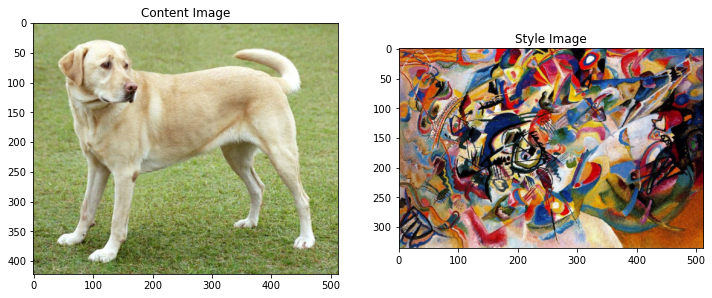

In [6]:
# load images
content_image = load_image(path_to_image=content_path)
style_image = load_image(path_to_image=style_path)

# show images
plt.subplot(1, 2, 1)
show_image(content_image, 'Content Image')
plt.subplot(1, 2, 2)
show_image(style_image, "Style Image")

In [7]:
'''
## Trying out tensorflow's original style-transfer algorithm
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)
'''

"\n## Trying out tensorflow's original style-transfer algorithm\nimport tensorflow_hub as hub\nhub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')\nstylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]\ntensor_to_image(stylized_image)\n"

In [8]:
input = tf.keras.applications.vgg19.preprocess_input(content_image*255)
input = tf.image.resize(input, (224, 224)) # VGG model requires input of 224 pixels
model_dir = "D:\\Git Repos\\Machine_Learning\\New_Projects\\Neural_Style_Transfer\\models\\vgg_model"
vgg_model = tf.keras.models.load_model(model_dir)
prediction_probabilities = vgg_model(input) # get prediction probabilities for content_image
prediction_probabilities.shape

TensorShape([1, 1000])

In [9]:
# trying out the model to ensure it's used properly
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('Labrador_retriever', 0.49317113),
 ('golden_retriever', 0.23665296),
 ('kuvasz', 0.036357515),
 ('Chesapeake_Bay_retriever', 0.02418277),
 ('Greater_Swiss_Mountain_dog', 0.018646104)]

In [10]:
# load VGG19 model with no classification head
model_dir = "D:\\Git Repos\\Machine_Learning\\New_Projects\\Neural_Style_Transfer\\models\\vgg_model_no_head"
vgg_model = tf.keras.models.load_model(model_dir)

# list the layer names
print()
for layer in vgg_model.layers:
    print(layer.name)


input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [11]:
'''
The goal is to try to match the intermediate layers of the model with
the style and content of the input image.

A CNN image classification model is chosen because it's built as a complex feature
extractor before leading to an out classification label. This will be ideal for
describing content and style of input images for this use case.

The first few layers (e.g. conv1) represent low-level features like edges and
textures while the final few layers (e.g. conv2) represent higher-level features
like object parts( wheels, eyes...)
'''

content_layers = ['block5_conv2']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

# number of content layers
num_content_layers = len(content_layers)
# number of style layers
num_style_layers = len(style_layers)

In [12]:
def vgg_intermediate_layers(layer_names):
    """Creates a model that returns the list of intermediate layer output values

    Args:
        layer_names (list): list of names of the intermediate layers.

    Returns:
        tf.keras.Model: model with intermediate output values
    """
    model_dir = "D:\\Git Repos\\Machine_Learning\\New_Projects\\Neural_Style_Transfer\\models\\vgg_model_no_head"
    vgg = tf.keras.models.load_model(model_dir) # load no-head model
    vgg.trainable = False # freeze output layers of model

    outputs = [vgg.get_layer(name).output for name in layer_names] # get output_name of each layer

    model = tf.keras.Model([vgg.input], outputs) # create functional model with input and output arguments
    return model

In [13]:
# create the model
style_extractor = vgg_intermediate_layers(style_layers)
# preprocess the style image, then pass as input to style extractor model
style_outputs = style_extractor(style_image*255)

# visualise statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
    print(name)
    print(" shape: ", output.numpy().shape)
    print(" min: ", output.numpy().min())
    print(" max: ", output.numpy().max())
    print(" mean: ", output.numpy().mean())

block1_conv1
 shape:  (1, 336, 512, 64)
 min:  0.0
 max:  835.5256
 mean:  33.97525
block2_conv1
 shape:  (1, 168, 256, 128)
 min:  0.0
 max:  4625.8857
 mean:  199.82687
block3_conv1
 shape:  (1, 84, 128, 256)
 min:  0.0
 max:  8789.239
 mean:  230.78099
block4_conv1
 shape:  (1, 42, 64, 512)
 min:  0.0
 max:  21566.135
 mean:  791.24005
block5_conv1
 shape:  (1, 21, 32, 512)
 min:  0.0
 max:  3189.2542
 mean:  59.179478


In [14]:
def gram_matrix(input_tensor):
    """ Calculates gram matrix which describes the means and correlations across the
        different intermediate feature maps representing the content of an image.

    Args:
        input_tensor (tf.Tensor): input image as tensor.

    Returns:
        float: calculated style
    """

    # implement gram matrix equation
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

In [15]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        """ Builds a custom model that returns the style and content tensors

        Attributes:
            self.vgg (tf.keras.models.Model) representing the vgg model with only the intermediate layers
            self.style_layers (list of layers) a list of style layers from the intermediate layers
            self.content_layers (list of layers) a list of content layers from the intermediate layers
            self.num_style_layers (int) total number of intermediate style layers
        """
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_intermediate_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False # freeze model layers

    def call(self, inputs):
        """Expects float input between 0 and 1"

        Args:
            inputs (tf.Tensor): image inputs

        Returns:
            dict: dictionary containing content and style tensor dictionaries
        """
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        # separating style and content layers from model outputs
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        # applying gram matrix on style layer outputs
        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        # zip content layer names and outputs into dictionary
        content_dict = {content_name: value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}

        # zip style layer names and outputs into dictionary
        style_dict = {style_name: value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}

In [16]:
extractor = StyleContentModel(style_layers, content_layers) # define extractor model

results = extractor(tf.constant(content_image)) # apply the model on the content image

# visualize new layer output's statistics
print('Styles:')
for name, output in sorted(results['style'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())
    print()

print('Contents:')
for name, output in sorted(results['content'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())
    print()

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0055228453
    max:  28014.521
    mean:  263.7902

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  61479.484
    mean:  9100.949

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  545623.44
    mean:  7660.976

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  4320501.0
    mean:  134288.84

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  110005.34
    mean:  1487.0381

Contents:
   block5_conv2
    shape:  (1, 26, 32, 512)
    min:  0.0
    max:  2410.8796
    mean:  13.764149



In [17]:
# set style and content target values
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

# defining a tf.variable to hold the content image
image = tf.Variable(content_image)

In [18]:
def clip_0_to_1(image):
    """Compresses image values between 0 and 1

    Args:
        image (float): float image inputs

    Returns:
        float list: outputs image with values between 0 and 1
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [19]:
# create an optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

# use weighted combination of style and content weights to get total loss
style_weight=1e-2
content_weight=1e4

In [20]:
def style_content_loss(model_outputs):
    """Uses mean squared error to calculate the loss for image's output relative to
        each target and taking the weighted sum of the losses

    Args:
        model_outputs (tf.Tensor): output of the model

    Returns:
        float: mean squared error loss
    """
    style_outputs = model_outputs['style']
    content_outputs = model_outputs['content']
    # calculate mean squared error for all style outputs
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    # calculate mean squared error for all content outputs
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                           for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    return style_loss + content_loss # return weighted sum of losses

In [21]:
@tf.function
def training_step(image):
    """Function to train the model and update with the specified optimizer"

    Args:
        image (tf.Tensor): image inputs

    Returns: None
    """
    # use tf.gradienttape to update the image
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss((outputs))

    grad = tape.gradient(loss, image) # apply tf.GradientTape
    opt.apply_gradients([(grad,image)]) # apply optimizer
    image.assign(clip_0_to_1(image)) # apply effect on image

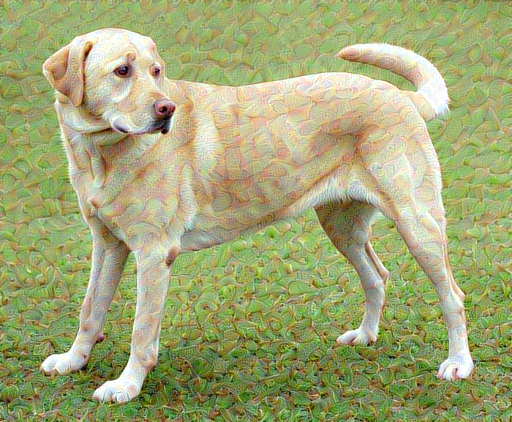

In [22]:
# run a few steps to test
training_step(image)
training_step(image)
training_step(image)
tensor_to_image(image)

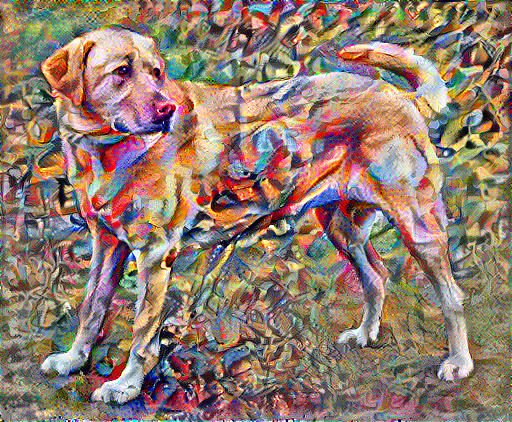

Train step: 1000
Total time: 117.1


In [23]:
# perform a longer optimization
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for epoch in range(epochs):
    for step_count in range(steps_per_epoch):
        step += 1
        training_step(image)
        print(".", end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print(f"Train step: {step}")

end = time.time()
print("Total time: {:.1f}".format(end-start))

In [24]:
# reduce high frequency artifacts using explicit regularization term
# on high frequency components of image

def high_pass_x_y(image):
    """Applies high pass filter in hotrizontal and vertical aspects of the image

    Args:
        image (tf.Tensor): image input

    Returns:
        tuple: oututs vertical and horizontal high pass of image
    """
    x_aspect = image[:, :, 1:, :] - image[:, :, :-1, :]
    y_aspect = image[:, 1:, :, :] - image[:, :-1, :, :]
    return x_aspect, y_aspect

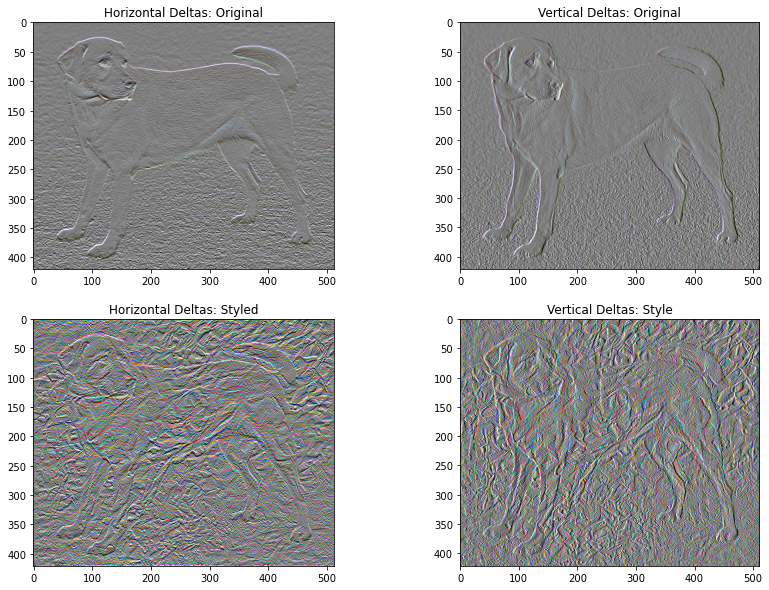

In [25]:
x_deltas, y_deltas = high_pass_x_y(content_image) # apply high pass on content image

plt.figure(figsize=(14,10))
# display horizontal high pass original image
plt.subplot(2, 2, 1)
show_image(clip_0_to_1(2*y_deltas+0.5), "Horizontal Deltas: Original")
# display vertical high pass original image
plt.subplot(2, 2, 2)
show_image(clip_0_to_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image) # apply high pass on content image

# display horizontal high pass styled image
plt.subplot(2, 2, 3)
show_image(clip_0_to_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")
# display vertical high pass styled image
plt.subplot(2, 2, 4)
show_image(clip_0_to_1(2*x_deltas+0.5), "Vertical Deltas: Style")

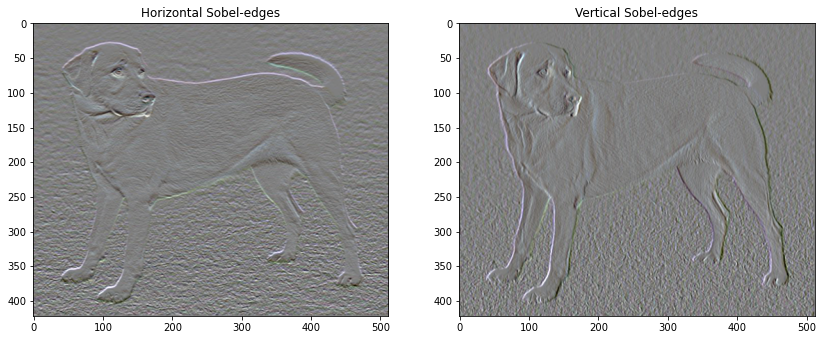

In [26]:
# This high frequency component is basically an edge detector.
# You can achieve the same output using the sobel edge detector
plt.figure(figsize=(14, 10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1,2,1)
show_image(clip_0_to_1(sobel[..., 0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1,2,2)
show_image(clip_0_to_1(sobel[..., 1]/4+0.5), "Vertical Sobel-edges")

In [27]:
def total_variation_loss(image):
    """Produce regularization loss which is the sum of the squares of input values

    Args:
        image (tf.Tensor): image input

    Returns:
        float: regularization loss
    """
    x_deltas, y_deltas = high_pass_x_y(image)
    return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [28]:
# apply total variation loss regulariization on image
total_variation_loss(image).numpy()

149291.86

In [29]:
# although tensorflow already has a function for this
print(tf.image.total_variation(image).numpy())

[149291.86]


In [30]:
''' Rerun the optimization '''
# choose weight for total variation loss
total_variation_weight = 30

# include it in the new variation loss
@tf.function
def training_step(image):
    """Function to train the model and update with the specified optimizer"

    Args:
        image (tf.Tensor): image inputs

    Returns: None
    """
    # use tf.gradienttape to update the image
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss((outputs))
        # add regularization
        loss += total_variation_weight*tf.image.total_variation(image)

    grad = tape.gradient(loss, image) # apply tf.GradientTape
    opt.apply_gradients([(grad,image)]) # apply optimizer
    image.assign(clip_0_to_1(image)) # apply effect on image

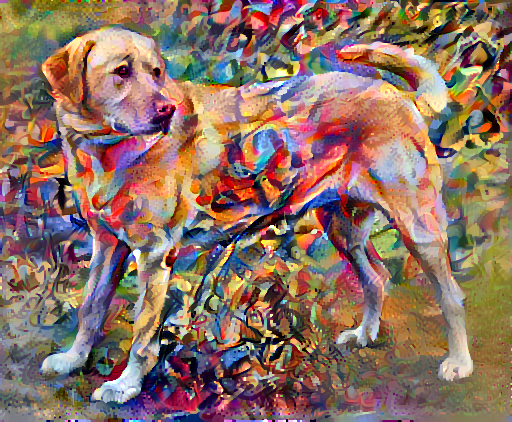

Train step: 1000
Total time: 120.5


In [31]:
# reinitialize the optimization variable
image = tf.Variable(image)

# rerun initialization
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for epoch in range(epochs):
    for step_count in range(steps_per_epoch):
        step += 1
        training_step(image)
        print(".", end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print(f"Train step: {step}")

end = time.time()
print("Total time: {:.1f}".format(end-start))